# Test sanssouci on synthetic data

In this introductory notebook, we test the *sanssouci* module on synthetic data. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt

sanssouci_dir='../'
import sys
sys.path.append(sanssouci_dir)
import sanssouci as sa

import random


## 1. Generate phantom data

We observe $n=n_0 + n_1$ independent $p$-dimensional vectors $X^{(j)} \sim \mathcal{N}(\mu^{(0)},\Sigma)$ for $1\leq j \leq n_0$, and  $X^{(j)} \sim \mathcal{N}(\mu^{(1)},\Sigma)$ for $1\leq j \leq n_1$. Our goal is to test for each feature $i = 1 \dots p$ the null hypothesis: $\mathcal{H}_{0,i}: \theta^{(0)}_i=\theta^{(1)}_i$. 

We denote by $p_0$ the number of true null hypotheses (that is, the number of noise features) and by $\pi_0 = p_0/p$ the fraction of true nulls (that is, the proportion of noise in the data). 

We assume that:

- $\Sigma = \rho + (1-\rho) I_p$, meaning that the correlation between any two variables is $\rho$; the case $\rho=0$ corresponds to independent tests. 

- for $i = 1, \cdots, p_0$, $\mu^{(0)} = \mu^{(1)} = 0$
- for $i = p_0+1, \cdots, p$, $\mu^{(0)} = 0$ and $\mu^{(1)} = s$, where $s$ controls the signal to noise ratio of the problem.

For each feature, the null hypothesis: $\mathcal{H}_{0,i}: \theta^{(0)}_i=\theta^{(1)}_i$ is tested by a two-sample Welch test. 

The simulation parameters are set as follows.

In [2]:
random.seed(a=2021)

p = 50000         # number of features     (eg : number of voxels in an image)
n = 80            # number of observations  (eg : number of images)
pi0 = 0.99        # proportion of noise (true null hypotheses)
p0 = int(np.round(pi0*p)) # number of true null hypotheses (non active voxels)
rho = 0.3         # equi-correlation
s = 1             # signal to noise ratio

# generate noise
Z=np.random.randn(n,p)
w=np.random.randn(n)
W=Z.copy()
for i in range(p):
  W[:,i]=w[:]
Y=np.sqrt(1-rho)*Z + np.sqrt(rho)*W

# add signal (for false null hypotheses)
categ=np.random.binomial(1, 0.5, size=n) # two balanced categories
X = Y.copy()
w1=np.where(categ==1)
X[w1, (p0+1):p] = Y[w1, (p0+1):p] + s


We perform Welch $t$-tests on each feature to assess whether the mean values are significantly different between the two groups of observations. The histogram of the $p=50000$ p-values is shown below.

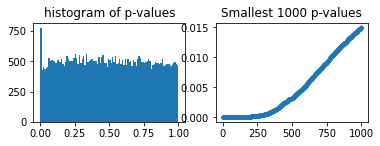

In [3]:
# calculate and display the p-values
rwt=sa.row_welch_tests(X, categ)
pval = rwt['p_value']

plt.subplot(2, 2, 1)
plt.hist(pval, 100)  #100 bins are used for the histogram
plt.title('histogram of p-values')

s_pval = np.sort(pval)
plt.subplot(2, 2, 2)
plt.plot(s_pval[:1000], '.')
plt.title('Smallest 1000 p-values')

plt.show()


In order to define which features are "significantly" associated, we need to take into account the fact that a large number of tests are performed in parallel. This calls for the use of multiple testing corrections. 



## 2. Classical multiple testing: FDR control

A standard way to account for the fact that we are performing many tests simultaneously is to control the False Discovery Rate (FDR). The FDR of a subset of features is the expected proportion of false positives in this set. This is classically done using the Benjamini-Hochberg (1995) procedure.

The Benjamini-Hochberg (BH) procedure at level $\alpha$ rejects the smallest $I$ $p$-values, where $I$ is the largest crossing point between the sorted $p$-values and the line passing by $(0,0)$ and $(p, \alpha)$:

p_i: 0.0006383953945765519
i: 327


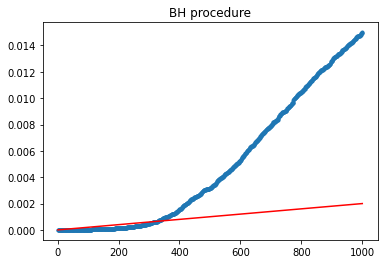

In [10]:
# adapted from https://matthew-brett.github.io/teaching/fdr.html
alpha = 0.1
s_pval = np.sort(pval)
i = np.arange(1, p+1) # the 1-based i index of the p values, as in p(i)

plt.plot(i[:1000], s_pval[:1000], '.')
plt.plot(i[:1000], alpha * i[:1000] / p, 'r')
plt.title("BH procedure")

below = s_pval < (alpha * i / p)   # True where p(i)<qi/N
I = np.max(np.where(below)[0]) + 1 # Max Python array index where p(i)<qi/N
print('p_i:', s_pval[I-1])
print('i:', I) # Python indices 0-based, we want 1-based


Here, the BH procedure ensures that the FDR, that is, the expected proportion of false positives (FDP) among the 427 selected variables is less than 0.1. 

### Intrinsic limitations of FDR control

As noted by Goeman and Solari (2011), an important limitation to the above approach is that FDR controlling procedures output a single set of "significant features", whereas users are typically interested in other subsets of features. 

Another caveat is that FDR control (which is by definition a control in expectation), may not be interpretable in the situation where the underlying FDP is highly variable. Unfortunately, this situation is common in high-dimensional data sets with non independent features, in particular in genomics and neuroimaging.

Because we are working with simuated data, we can actually calculate the true False Discovery Proportion (FDP) as done in the next cell. However, this could not be done when analyzing actual data.

In [12]:
i0 = np.arange(1, p0+1)
below0 = pval[:p0] < (alpha * (I-1) / p)
FP = np.sum(below0)
print('FP:', FP)

FDP = FP/I
print('FDP:', FDP)

FP: 10
FDP: 0.03058103975535168


## 3. Post hoc inference

In order to bypass these limitations, post hoc inference makes it possible to *build confidence statements on the number of true/false positives within any set $S$ of selected variables*: $S$ may be selected after seing the data (e.g., $S$ may be the set of rejections by the BH procedure), and multiple choices of $S$ are allowed. Post hoc inference has been popularized by Goeman and Solari (2011) and its application to neuroimaging data is illustrated in Rosenblatt *et al*, 2018.  This approach is implemented in the R package 'ARI', which relies on the R package 'cherry'.

Below, we use an equivalent formulation of the bound of Goeman and Solari (2011) implemented in the python package 'sansSouci.python'. 

### Upper bound on $p_0$

We obtain an upper bound on $p_0$, the number of true null hypotheses, by taking $S=$ all $p$ hypotheses. With probability $1-\alpha = 0.9$ the number of true null hypotheses is less than this bound:

In [13]:
alpha = 0.1
thr=sa.t_linear(alpha, np.arange(1,p+1), p)

bound = sa.max_fp(pval, thr)
print("\nbound:",bound)
print('\nNumber of true null hypotheses:', p0)


bound: 49862.0

Number of true null hypotheses: 49500


### Number of false positives by BH

Post hoc inference allows the user to select any subset of features $S$ of interest. In particular, we can chose $S$ as the set of features selected by the BH procedure.

In [14]:
bound = sa.max_fp(s_pval[np.where(below)], thr)
print("\nGS2011 post hoc bound:", bound)
print('\nTrue number of false positives:', FP)


bound: 189.0

Number of false positives: 10


In this particular example, the bound is substantially larger than the true number of false positives, meaning that the GS2011 bound is conservative.

### Confidence curves for the FDP

Confidence curves for the False Discovery Proportion are another typical output of post hoc inference. These curves display post hoc bounds as a function of the number of most significant features retained. The user may choose how many features to retain based on the value of the bound. 

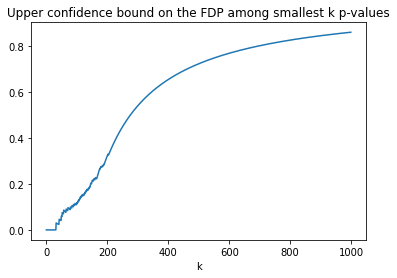

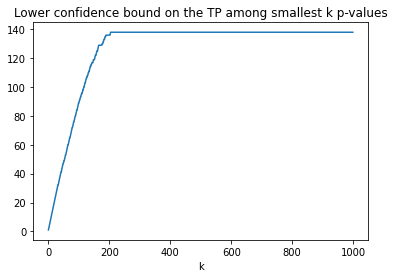

In [15]:
maxFP = sa.curve_max_fp(s_pval, thr)
maxFDP = maxFP/i
minTP = i - maxFP

plt.plot(maxFDP[:1000], )
plt.title("Upper confidence bound on the FDP among smallest k p-values")
plt.xlabel("k")
plt.show()

plt.plot(minTP[:1000], )
plt.title("Lower confidence bound on the TP among smallest k p-values")
plt.xlabel("k")
plt.show()

## 4. Improved post hoc inference by adaptation to the dependence

As discussed in Blanchard, Neuvial, and Roquain (2020), the above-described bound is known to be valid only under certain positive dependence assumptions (PRDS) on the joint $p$-value distribution. Although the PRDS assumption is widely accepted for fMRI studies (see Genovese, Lazar, and Nichols (2002), Nichols and Hayasaka (2003)), we argue (and demonstrate below) that this assumption yields overly conservative post hoc bounds. Indeed, the Simes bound is by construction not adaptive to the specific type of dependence at hand for a particular data set.

To bypass these limitations, Blanchard, Neuvial, and Roquain (2020) have proposed a randomization-based procedure known as $\lambda$-calibration, which yields tighter bounds that are adapted to the dependency observed in the data set at hand. We note that a related approach has been proposed by Hemerik, Solari, and Goeman (2019), and Andreella *et al* (2020) (https://arxiv.org/abs/2012.00368).  In the case of two-sample tests, this calibration can be achieved by permutation of class labels, which is available in the sansSouci.python package:

In [17]:
B = 1000
pval0 = sa.get_perm_p(X, categ, B=B , row_test_fun=sa.row_welch_tests)
piv_stat = sa.get_pivotal_stats(pval0, K=p)
lam = np.quantile(piv_stat, alpha)

print('\nalpha:', alpha)
print('\nlambda:', np.round(lam, 2))


alpha: 0.1

lambda: 0.26


Here we obtain $\lambda > \alpha$. This practically means that in order to obtain post hoc statements at confidence level $1-\alpha$, the user can use the GS2011 bound at level $\lambda$. As  $\lambda > \alpha$, this means that the new proposed bound will tighter (ie, less conservative) than the original GS2011 bound. The gap between $\lambda$ and $\alpha$ can be interpreted as the power gain obtained by $\lambda$-calibration, which is illustrated below.

### Upper bound on 𝑝0, the number of true null hypotheses

We obtain an upper bound on $p_0$, the number of true null hypotheses, by taking $S=$ all $p$ hypotheses. With probability $1-\alpha = 0.9$ the number of true null hypotheses should be less than this bound:

In [18]:
thr_cal=sa.t_linear(lam, np.arange(1,p+1), p)

bound = sa.max_fp(pval, thr_cal)
print("\nbound:",bound)
print('\nNumber of true null hypotheses:', p0)


bound: 49783.0

Number of true null hypotheses: 49500


As expected, the bound is still valid, and tighter than before.

### Number of false positives by BH

We now calculate an upper bound on the number of false positives among the hypotheses rejected by the BH procedure.

In [19]:
bound = sa.max_fp(s_pval[np.where(below)], thr)
bound_cal = sa.max_fp(s_pval[np.where(below)], thr_cal)
print("\nGS2011 post hoc bound:", bound)
print("\nBNR2020 post hoc bound:", bound_cal)
print('\nTrue number of false positives:', FP)



GS2011 post hoc bound: 189.0

BNR2020 post hoc bound: 110.0

True number of false positives: 10

bound: 189.0

Number of false positives: 10


Again, the BNR2020 bound is still valid, and tighter than the GS2011 bound.

### Confidence envelopes for the FDP



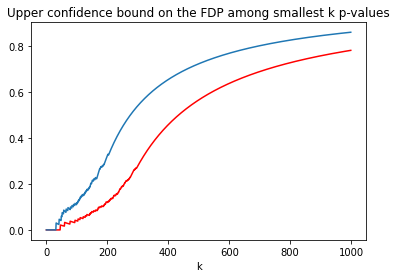

In [20]:
maxFP_cal = sa.curve_max_fp(s_pval, thr_cal)
maxFDP_cal = maxFP_cal/i

plt.plot(maxFDP_cal[:1000], '-r', label = 'Simes')
plt.plot(maxFDP[:1000], '-', label = 'Simes + lambda-calibration')
plt.title('Upper confidence bound on the FDP among smallest k p-values')
plt.xlabel('k')
plt.show()

The upper bound obtained by $\lambda$-calibration (in red) is uniformly tighter than the original "parametric" one.

## References


Blanchard, Gilles, Pierre Neuvial, and Etienne Roquain. 2020. “Post Hoc Confidence Bounds on False Positives Using Reference Families.” Annals of Statistics 48 (3): 1281–1303. https://projecteuclid.org/euclid.aos/1594972818.

Goeman, Jelle J, and Aldo Solari. 2011. “Multiple Testing for Exploratory Research.” Statistical Science 26 (4): 584–97.

Hemerik, Jesse, Aldo Solari, and Jelle J Goeman. 2019. “Permutation-Based Simultaneous Confidence Bounds for the False Discovery Proportion.” Biometrika 106 (3): 635–49.
